## Network Analysis on Bitcoin OTC
### Abdouh Harouna Kenfack

### Dataset Description
* This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1


* This is a weighted and directed network
    * For simplified analysis, we would be switching between weighted to unweighted and from directed to undirected as need be.


* Dataset format
    * SOURCE, TARGET, RATING, TIME
    
    
* Nodes: 5881


* Edges: 35,592


### Importing some libraries

In [2]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
# pip install decorator==5.0.9
from scipy.sparse import csr_matrix
import numpy as np
import graspologic as gs
import pandas as pd

In [162]:
#Navigating to my notebook
cd /content/drive/MyDrive/Colab Notebooks/Network-DataScience

In [4]:
data = pd.read_csv (r'soc-sign-bitcoinotc.csv')

data.rename(columns = {'6':'From-N', 
                    '2':'To-N',
                    '4':'Weight',
                    '1289241911.72836':'Time'},
         inplace=True)

data = data.drop(['Time'], axis = 1)

#Creating directed graph
G = nx.DiGraph()
G.add_weighted_edges_from([tuple(x) for x in data.values])

nodelist = G.nodes

A = nx.to_scipy_sparse_matrix(G, nodelist) # Sparse matrix

A_Dense = nx.to_numpy_array(G, nodelist) # Dense Matrix

### Heat Map of entire network!
    * Shows its pretty sparse
    * Ploted a smaller network for better visualization

<AxesSubplot:>

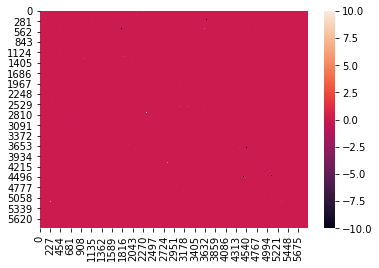

In [10]:
import seaborn as sns

sns.heatmap(A_Dense)

<AxesSubplot:>

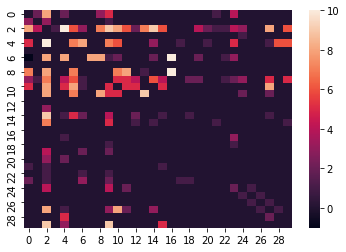

In [41]:
sns.heatmap(A_Dense[:30,:30])

### Graphical layout of network
* Shows its pretty Dense
* Ploted a truncated version for display

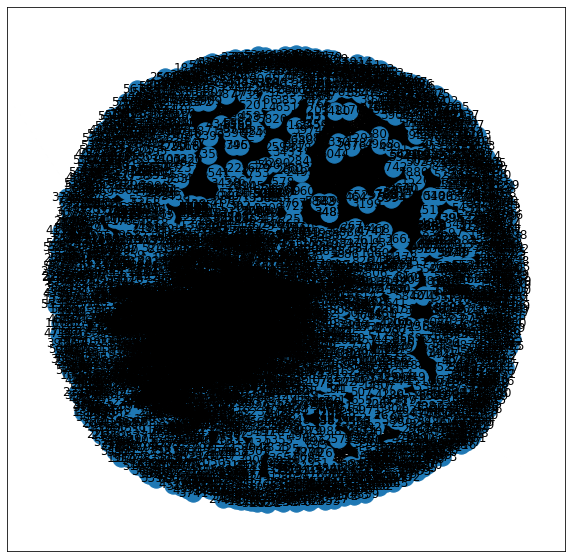

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx(G, ax=ax)

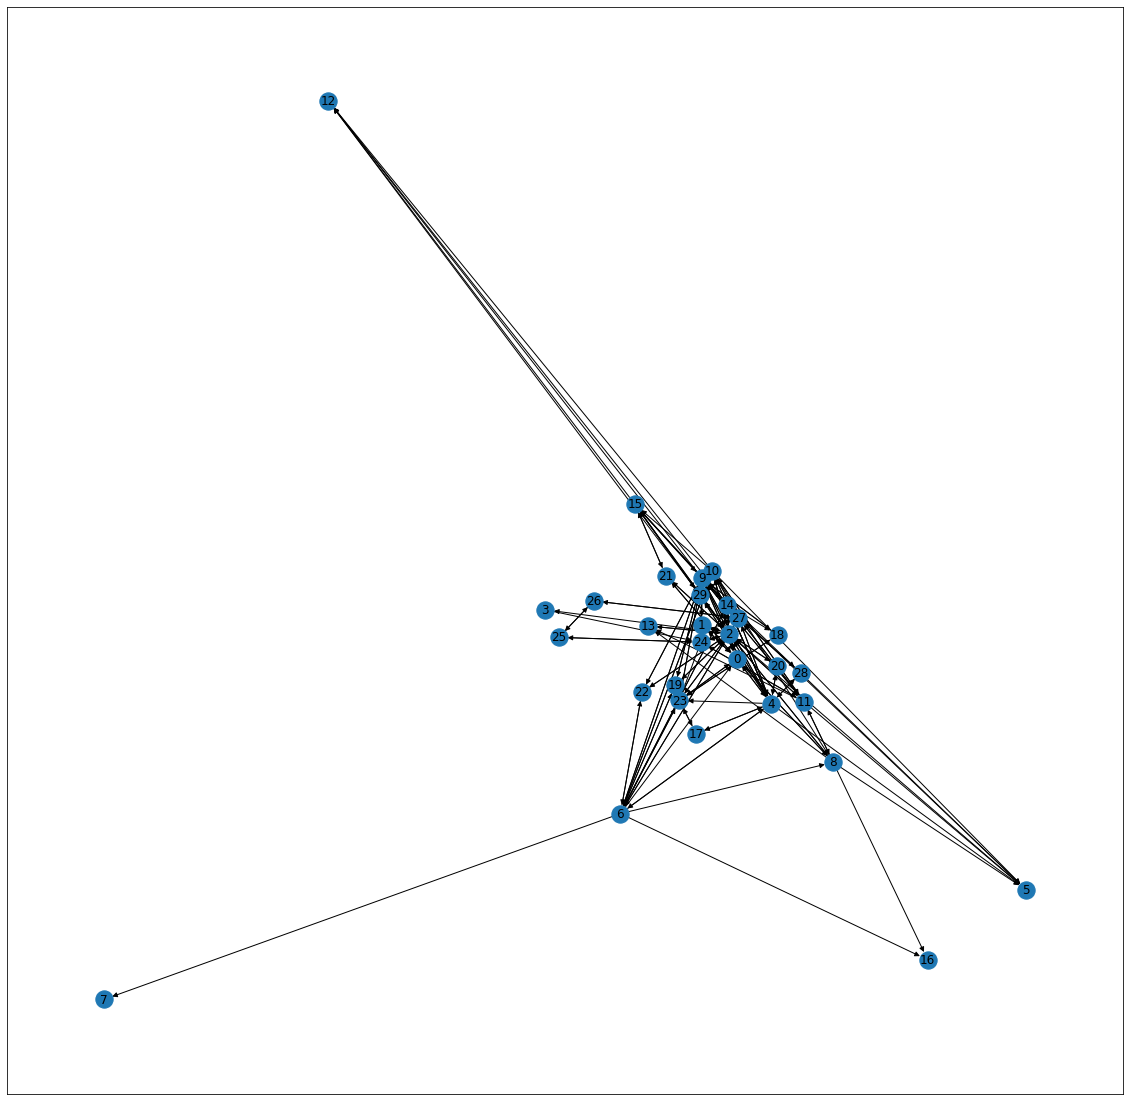

In [39]:
G_trun = nx.from_numpy_array(A_Dense[:30,:30], create_using=nx.DiGraph)
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
nx.draw_networkx(G_trun, ax=ax)

### Node Analysis
* Since I am dealing with a weighted network, I will find the degree using Out and In degrees and find the maximum degree for each

In [67]:
out_degrees = dict(G.out_degree())
#map_to_nodes(out_degrees)
Out_max = max(out_degrees.values())
Out_min = min(out_degrees.values())

In [68]:
in_degrees = dict(G.in_degree())
In_max = max(in_degrees.values())
In_min = min(in_degrees.values())

In [69]:
print(In_max, In_min, Out_max, Out_min)

535 0 763 0


In [ ]:
def map_to_nodes(node_map):
    node_map.setdefault(0)
    # utility function to make it easy to compare dicts to array outputs
    return np.array(np.vectorize(lambda x: node_map.setdefault(x, 0))(nodelist))

In [71]:
map_to_nodes(dict(nx.eigenvector_centrality(G)))

array([4.73862421e-02, 5.80161757e-03, 1.35403106e-01, ...,
       4.95160572e-05, 3.36789851e-03, 3.36789851e-03])

### Weighted to Unweighted 
* Creating an unweighted network to ease calculations

In [72]:
unW_G = nx.from_pandas_edgelist(data, "From-N", "To-N")

In [74]:
A_unDense = nx.to_numpy_array(unW_G, nodelist)
G_un = nx.from_numpy_array(A_unDense, create_using=nx.DiGraph)

In [88]:
nx.is_weakly_connected(G_un)

False

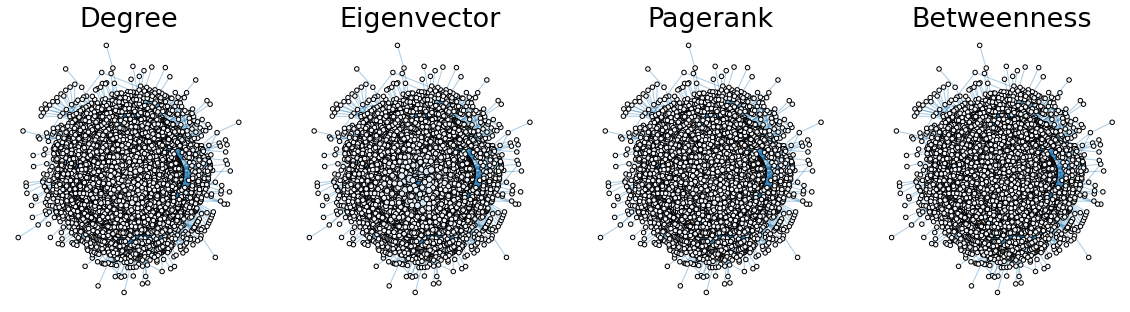

In [78]:
A = A_unDense
g = G_un

import pandas as pd
import matplotlib.pyplot as plt
from graspologic.plot import networkplot
import seaborn as sns
from matplotlib import colors

node_data = pd.DataFrame(index=g.nodes())
node_data["degree"] = node_data.index.map(dict(nx.degree(g)))
node_data["eigenvector"] = node_data.index.map(nx.eigenvector_centrality(g))
node_data["pagerank"] = node_data.index.map(nx.pagerank(g))
node_data["betweenness"] = node_data.index.map(nx.betweenness_centrality(g))

pos = nx.kamada_kawai_layout(g)
node_data["x"] = [pos[node][0] for node in node_data.index]
node_data["y"] = [pos[node][1] for node in node_data.index]

sns.set_context("talk", font_scale=1.5)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))


def plot_node_scaled_network(A, node_data, key, ax):
    # REF: https://github.com/mwaskom/seaborn/blob/9425588d3498755abd93960df4ab05ec1a8de3ef/seaborn/_core.py#L215

    levels = list(np.sort(node_data[key].unique()))
    cmap = sns.color_palette("Blues", as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    networkplot(
        A,
        node_data=node_data,
        x="x",
        y="y",
        ax=ax,
        edge_linewidth=1.0,
        node_size=key,
        node_hue=key,
        palette=palette,
        node_sizes=(20, 200),
        node_kws=dict(linewidth=1, edgecolor="black"),
        node_alpha=1.0,
        edge_kws=dict(color=sns.color_palette()[0])
    )

    ax.axis("off")
    ax.set_title(key.capitalize())


ax = axs[0]
plot_node_scaled_network(A_unDense, node_data, "degree", ax)

ax = axs[1]
plot_node_scaled_network(A_unDense, node_data, "eigenvector", ax)

ax = axs[2]
plot_node_scaled_network(A_unDense, node_data, "pagerank", ax)

ax = axs[3]
plot_node_scaled_network(A_unDense, node_data, "betweenness", ax)

fig.set_facecolor("w")

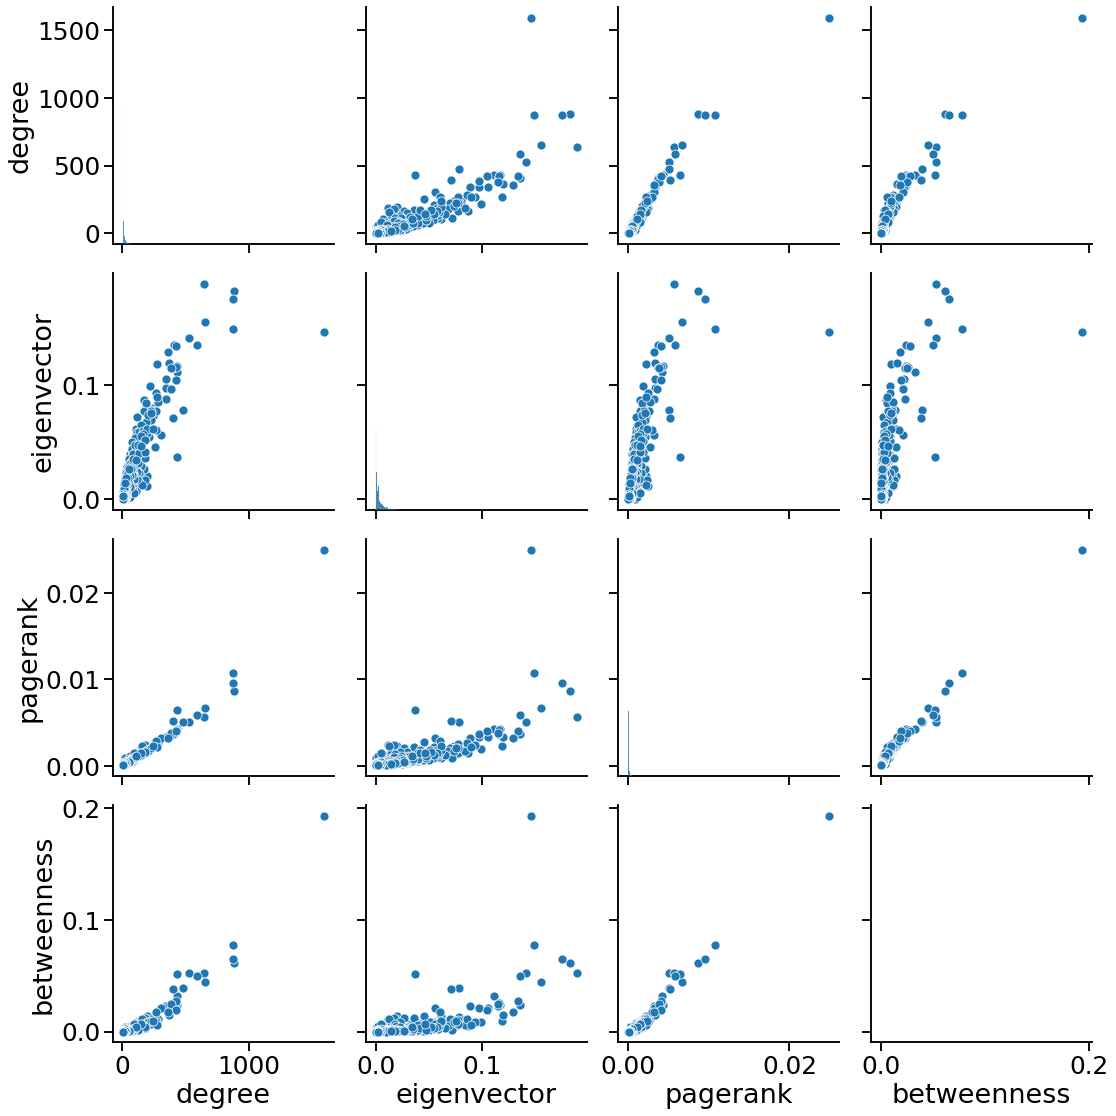

In [89]:
sns.pairplot(node_data, vars=['degree', 'eigenvector', 'pagerank', 'betweenness'], height=4)

<AxesSubplot:xlabel='x', ylabel='y'>

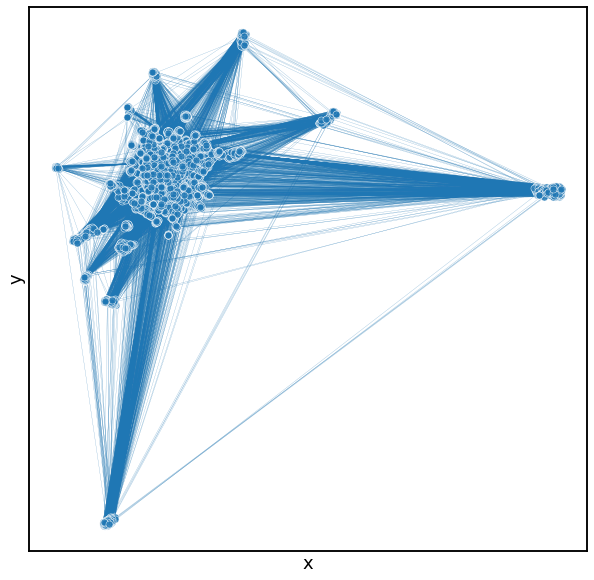

In [77]:
# A_ptr = gs.utils.pass_to_ranks(A_unDense)  # can skip for an unweighted network
A_sparse = csr_matrix(A_unDense)

n_components = 15
ase = gs.embed.AdjacencySpectralEmbed(n_components=n_components, check_lcc=False)
ase_embedding = ase.fit_transform(A_sparse)

from umap import UMAP

umapper = UMAP(n_neighbors=15, metric="cosine", min_dist=0.8)
umap_embedding = umapper.fit_transform(ase_embedding)

gs.plot.networkplot(
    A_sparse,
    x=umap_embedding[:, 0],
    y=umap_embedding[:, 1],
    edge_linewidth=0.2,
    edge_alpha=0.4,
    node_kws=dict(
        s=50,  # s will change the size of nodes)
    ),
)

<AxesSubplot:>

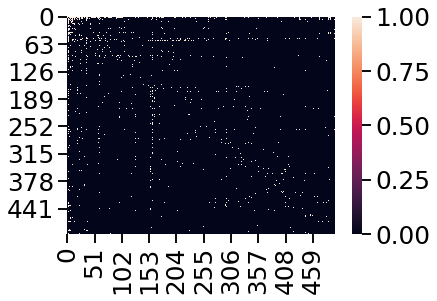

In [81]:
sns.heatmap(A_unDense[:500,:500])

<AxesSubplot:>

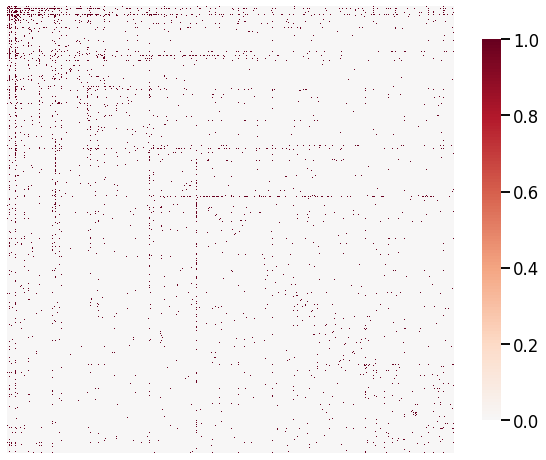

In [85]:
#from graspologic.plot import heatmap

heatmap(A_unDense[:500,:500], cbar=True)

### Community Detection
* Greedy Modularity

In [164]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(G_un))


In [166]:
print('Number of detected communities: ', len(c))

Number of detected communities:  49


In [90]:
from graspologic.utils import largest_connected_component

A_lcc = largest_connected_component(A_unDense)
A_lcc.shape

(5875, 5875)

In [168]:
print("The largest connected network looks like: ", A_lcc)

The largest connected network looks like:  [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## What Next?

In [185]:
#adj = nx.to_scipy_sparse_matrix(G_un, nodelist=nodelist)
adj = nx.to_numpy_array(G_unD, nodelist=nodelist)

from graspologic.plot import networkplot

node_data["degree"] = np.array(np.sum(adj, axis=1))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = networkplot(
    adj,
    x="umap_0",
    y="umap_1",
    node_data=nodes.reset_index(),
    node_hue="label",
    node_size="degree",
    node_sizes=(10, 200),
    ax=ax,
    edge_linewidth=0.2,
    edge_alpha=0.2,
)
_ = ax.axis("off")

In [115]:
adj = pd.read_csv("soc-sign-bitcoinotc.csv", header=None)

In [113]:
from graspologic.embed import node2vec_embed

node2vec_embedding, node_ids = node2vec_embed(
    G,
    dimensions=16,
    num_walks=10,
    walk_length=16,
    inout_hyperparameter=1.0,
    return_hyperparameter=1.0,
    random_seed=8888,
)

/opt/anaconda3/lib/python3.8/site-packages/graspologic/embed/n2v.py:445: RuntimeWarning: divide by zero encountered in true_divide
  float(u_prob) / norm_const for u_prob in unnormalized_probs
/opt/anaconda3/lib/python3.8/site-packages/graspologic/embed/n2v.py:513: RuntimeWarning: invalid value encountered in double_scalars
  alias[large] = alias[large] + alias[small] - 1.0
/opt/anaconda3/lib/python3.8/site-packages/graspologic/embed/n2v.py:413: RuntimeWarning: divide by zero encountered in double_scalars
  normalized_probs = [float(u_prob) / norm_const for u_prob in unnormalized_probs]


In [129]:
A_Dense.shape

(5881, 5881)

In [136]:
nodesN = list(G.nodes)
len(nodesN)

5881

In [183]:
adj = nx.to_numpy_array(G_unD, nodelist=nodelist)

In [186]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=4, metric="euclidean")
nn.fit(node2vec_embedding)

query_node = 1

dists, neighbor_indices = nn.kneighbors(
    node2vec_embedding[query_node, :].reshape(1, -1)
)

neighbor_indices = np.squeeze(neighbor_indices)
neighbor_indices

ax = networkplot(
    adj,
    x="umap_0",
    y="umap_1",
    node_data=nodes.reset_index(),
    node_hue="label",
    node_size="degree",
    node_sizes=(70, 500),
    edge_linewidth=0.8,
    edge_alpha=0.8,
)
ax.axis("off")


def get_location(node_index):
    return np.array(nodes.iloc[node_index][["umap_0", "umap_1"]])


center = get_location(query_node)
pad = 0.9
ax.set(xlim=(center[0] - pad, center[0] + pad), ylim=(center[1] - pad, center[1] + pad))
_ = ax.figure.set_facecolor("w")


def annotate(node_index, text, ax):
    xy = get_location(node_index)
    ax.annotate(
        text,
        xy,
        xytext=(30, 30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->"),
    )


annotate(query_node, "Query node", ax)

for i, node_index in enumerate(neighbor_indices[1:]):
    annotate(node_index, i + 1, ax)

In [145]:
from graspologic.partition import leiden, modularity
from graspologic.utils import symmetrize, is_symmetric


A_sym = symmetrize(A_unDense)

leiden_partition_map = leiden(A_sym, random_seed=7)
type(leiden_partition_map)

dict

In [147]:
G_unD = G_un.to_undirected()

In [157]:
adj = nx.to_numpy_array(G_unD, nodelist=nodelist)

In [151]:
modularity(G_unD, leiden_partition_map)

0.4872396349401466

In [153]:
leiden_partition_map = leiden(G_unD, random_seed=6)
modularity(G_unD, leiden_partition_map)

0.49986385327039123

In [155]:
node_df = pd.DataFrame(index=nodelist)

In [158]:
def plot_network_partition(adj, node_data, partition_key):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    networkplot(
        adj,
        x="x",
        y="y",
        node_data=node_df.reset_index(),
        node_alpha=0.9,
        edge_alpha=0.7,
        edge_linewidth=0.4,
        node_hue=partition_key,
        node_size="degree",
        edge_hue="source",
        ax=axs[0],
    )
    _ = axs[0].axis("off")

    _ = heatmap(
        adj,
        inner_hier_labels=node_data[partition_key],
        ax=axs[1],
        cbar=False,
        cmap="Purples",
        vmin=0,
        center=None,
        sort_nodes=True,
    )

    return fig, ax

In [187]:
#pos = nx.kamada_kawai_layout(G_unD)
xs = []
ys = []
for node in nodelist:
    xs.append(pos[node][0])
    ys.append(pos[node][1])
xs = np.array(xs)
ys = np.array(ys)

node_df["x"] = xs
node_df["y"] = ys

n = adj.shape[0]

node_df["degree"] = adj.sum(axis=0)

In [188]:
# node_df['leiden_partition'] = node_df.index.map(leiden_partition_map)

# plot_network_partition(adj, node_df, 'leiden_partition')

In [ ]:
# pip install graspologic
# https://snap.stanford.edu/data/soc-sign-bitcoin-otc.html